In [29]:
import torch
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt

import argparse
import os
import sys
import time

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import utils
from transformer_net import TransformerNet
from vgg import Vgg16

In [30]:
def train(args):
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])

    # Adjust the path to the downloaded WikiArt dataset
    train_dataset = datasets.ImageFolder(args.dataset, transform)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

    transformer = TransformerNet()
    optimizer = Adam(transformer.parameters(), args.lr)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16(requires_grad=False)
    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])

    # Adjust the path to your style image
    style = utils.load_image(args.style_image, size=args.style_size)
    style = style_transform(style)
    style = style.repeat(args.batch_size, 1, 1, 1)

    if args.cuda:
        transformer.cuda()
        vgg.cuda()
        style = style.cuda()

    style_v = Variable(style)
    style_v = utils.normalize_batch(style_v)
    features_style = vgg(style_v)
    gram_style = [utils.gram_matrix(y) for y in features_style]

    for e in range(args.epochs):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()
            x = Variable(x)
            if args.cuda:
                x = x.cuda()

            y = transformer(x)

            y = utils.normalize_batch(y)
            x = utils.normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = utils.gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= args.style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.data.item()
            agg_style_loss += style_loss.data.item()

            if (batch_id + 1) % args.log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                    agg_content_loss / (batch_id + 1),
                    agg_style_loss / (batch_id + 1),
                    (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

            if args.checkpoint_model_dir is not None and (batch_id + 1) % args.checkpoint_interval == 0:
                transformer.eval()
                if args.cuda:
                    transformer.cpu()
                ckpt_model_filename = "ckpt_epoch_" + \
                    str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
                ckpt_model_path = os.path.join(args.checkpoint_model_dir, ckpt_model_filename)
                torch.save(transformer.state_dict(), ckpt_model_path)
                if args.cuda:
                    transformer.cuda()
                transformer.train()

    # save model
    transformer.eval()
    if args.cuda:
        transformer.cpu()
    save_model_filename = "epoch_" + str(args.epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
        args.content_weight) + "_" + str(args.style_weight) + ".model"
    save_model_path = os.path.join(args.save_model_dir, save_model_filename)
    torch.save(transformer.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)

In [32]:
def main():
    main_arg_parser = argparse.ArgumentParser(description="parser for fast-neural-style")
    subparsers = main_arg_parser.add_subparsers(title="subcommands", dest="subcommand")

    train_arg_parser = subparsers.add_parser("train", help="parser for training arguments")
    train_arg_parser.add_argument("--epochs", type=int, default=2, help="number of training epochs, default is 2")
    train_arg_parser.add_argument("--batch-size", type=int, default=4, help="batch size for training, default is 4")
    train_arg_parser.add_argument("--dataset", type=str, required=True,
                                  help="path to training dataset, the path should point to a folder "
                                       "containing another folder with all the training images")
    train_arg_parser.add_argument("--style-image", type=str, default="images.jpg",
                                  help="path to style-image")
    train_arg_parser.add_argument("--save-model-dir", type=str, required=True, help="path to folder where trained model will be saved.")
    train_arg_parser.add_argument("--checkpoint-model-dir", type=str, default=None, help="path to folder where checkpoints of trained models will be saved")
    train_arg_parser.add_argument("--image-size", type=int, default=256, help="size of training images, default is 256 X 256")
    train_arg_parser.add_argument("--style-size", type=int, default=None, help="size of style-image, default is the original size of style image")
    train_arg_parser.add_argument("--cuda", type=int, required=True, help="set it to 1 for running on GPU, 0 for CPU")
    train_arg_parser.add_argument("--seed", type=int, default=42, help="random seed for training")
    train_arg_parser.add_argument("--content-weight", type=float, default=1e5, help="weight for content-loss, default is 1e5")
    train_arg_parser.add_argument("--style-weight", type=float, default=1e10, help="weight for style-loss, default is 1e10")
    train_arg_parser.add_argument("--lr", type=float, default=1e-3, help="learning rate, default is 1e-3")
    train_arg_parser.add_argument("--log-interval", type=int, default=500, help="number of images after which the training loss is logged, default is 500")
    train_arg_parser.add_argument("--checkpoint-interval", type=int, default=2000, help="number of batches after which a checkpoint of the trained model will be created")

    args = main_arg_parser.parse_args()

    if args.subcommand is None:
        print("ERROR: specify either train or eval")
        sys.exit(1)
    if args.cuda and not torch.cuda.is_available():
        print("ERROR: cuda is not available, try running on CPU")
        sys.exit(1)

    if args.subcommand == "train":
        check_paths(args)
        train(args)

if __name__ == "__main__":
    main()
    print('[===>] Task Finished!')


Done, trained model saved at cady.pth
[===>] Task Finished!


In [7]:
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(
            32, affine=True, track_running_stats=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3,
                               stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3,
                               stride=2)
        self.in3 = torch.nn.InstanceNorm2d(
            128, affine=True, track_running_stats=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(
            128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(
            64, affine=True, track_running_stats=True)
        self.deconv2 = UpsampleConvLayer(
            64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(
            32, affine=True, track_running_stats=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9,
                                 stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

In [8]:
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(
            channels, affine=True, track_running_stats=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(
            channels, affine=True, track_running_stats=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            #self.upsample_layer = torch.nn.UpsamplingNearest2d(scale_factor=upsample)

            #  nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)

        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = self.upsample_layer(x_in)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [25]:
def transform(model_path, image_path):
    # Load the pre-trained model
    #model_path = modelpath 
    model = TransformerNet()

    # Load the model state dict
    state_dict = torch.load(model_path)

    # Remove running stats keys if present (for compatibility with PyTorch 0.4.0 and later)
    state_dict = {k: v for k, v in state_dict.items() if not k.startswith('in2.running')}

    # Load the modified state dict into the model
    model.load_state_dict(state_dict)

    model.eval()

    # Define the content image path
    content_image_path = image_path

    # Load and preprocess the content image
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = Image.open(content_image_path).convert('RGB')
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0)
    content_image = Variable(content_image)

    # Stylize the content image
    with torch.no_grad():
        output_image = model(content_image)

    # Convert the output tensor to a NumPy array and remove batch dimension
    output_image_np = output_image.squeeze(0).numpy()

    # Display the stylized output
    plt.imshow(output_image_np.transpose(1, 2, 0).astype('uint8'))
    plt.axis('off')
    plt.show()

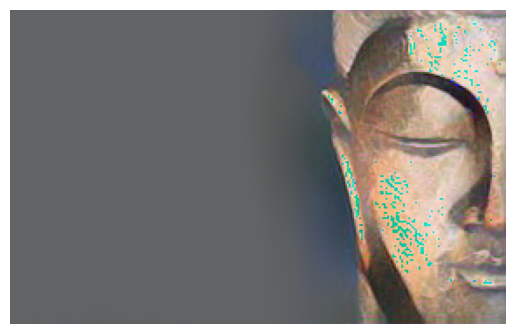

In [16]:
transform("udnie.pth", "images.jpg")

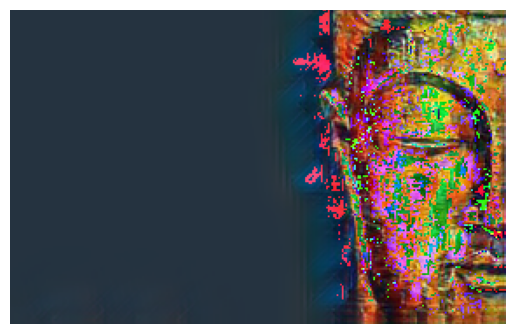

In [15]:
transform("rain_princess.pth", "images.jpg")

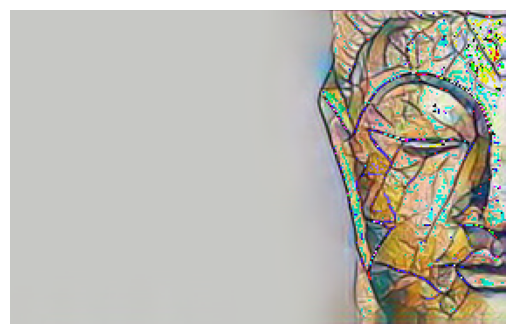

In [17]:
transform("mosaic.pth","images.jpg")

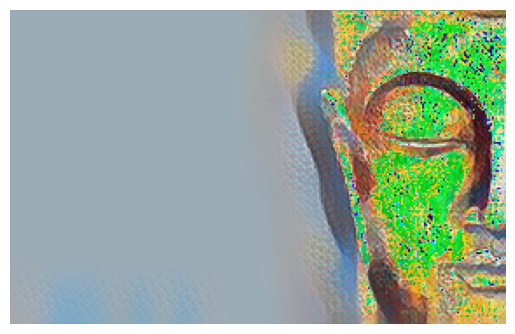

In [18]:
transform("candy.pth", "images.jpg")

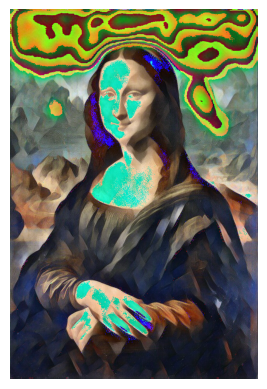

In [27]:
transform("udnie.pth", "Mona_Lisa.jpg")

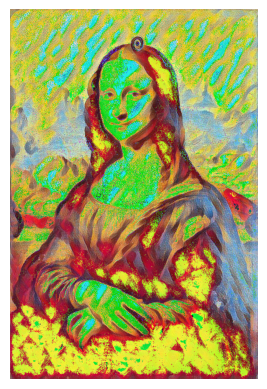

In [28]:
transform("candy.pth", "Mona_Lisa.jpg")